In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool
import shap


/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_who_ref = pd.read_excel('../WHO_tables/bmi-boys-perc-who2007-exp.xlsx')

In [4]:
# Define the age range and convert it to months
age_years = list(range(7, 19))  # From 7 to 18 years inclusive
age_months = [age * 12 for age in age_years]

# Filter the dataset for the specified months and select relevant columns
filtered_df = df_who_ref[df_who_ref['Month'].isin(age_months)][['Month', 'P5', 'P15', 'P85', 'P95']]

# Map months back to years for clarity
filtered_df['Age'] = filtered_df['Month'] // 12
filtered_df = filtered_df.drop(columns=['Month'])

filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,P5,P15,P85,P95,Age
0,13.504,14.166,17.111,18.261,7
1,13.666,14.350,17.508,18.802,8
2,13.866,14.579,17.987,19.453,9
3,14.127,14.875,18.568,20.225,10
4,14.469,15.260,19.260,21.113,11
5,14.891,15.734,20.052,22.090,12
6,15.402,16.303,20.943,23.144,13
7,15.976,16.941,21.891,24.221,14
8,16.547,17.580,22.812,25.229,15
9,17.078,18.176,23.656,26.126,16


In [6]:
df_5 = pd.read_spss('../final_data/caspian-5.sav',convert_categoricals=False)

In [7]:
def rename_features(df1,caspian_number):
    df2 = df1.copy()
    if caspian_number==1:
        df2.rename(columns={'univer': 'university','district':'region', 'schoolty':'schoolType'}, inplace=True)    
    elif caspian_number==3:
        df2.rename(columns={'area':'region', 'heighte':'height','weighte':'weight'}, inplace=True)    
    elif caspian_number==4:
        df2.rename(columns={'weight_1': 'weight', 'height_2': 'height', 'universi': 'university','waist_3':'waist','hip_4':'hip','wrist_5':'wrist'}, inplace=True)        
    elif caspian_number==5:
        df2.rename(columns={'weight_1': 'weight', 'height_2': 'height', 'universi': 'university','ap_9':'schoolType','waist_3':'waist','wrist4':'wrist'}, inplace=True)


    return df2

In [8]:
df_5=rename_features(df_5,5)

In [9]:
df_5.sex.unique()

array([0., 1.])

In [10]:
df_5 = df_5[df_5['sex']==1]

In [11]:
df_5 = df_5.drop(['var00001', 'univers0', 'region2', 'cluster2', 'cross2', 'sex2', 'birth_y0', 'sample_0'],axis=1)

In [12]:
def preprocess(dataframes_dict):
    processed_dfs = {}  # Dictionary to store processed DataFrames
    for name, df_org in dataframes_dict.items():
        df = df_org.copy()
        df.replace('', np.nan, inplace=True)
        df.replace('?', np.nan, inplace=True)
        # Filter age
        df = df[(df["age"] >= 7) & (df["age"] <= 18)]

        # Convert height and weight to numeric
        df['height'] = pd.to_numeric(df['height'], errors='coerce')
        df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

        # Calculate BMI
        df["bmi1"] = df["weight"] / ((df["height"] / 100) ** 2)

        # Remove null tuples
        records_with_nulls = df[
            df["sex"].isna()
        ]
        df = df.dropna(subset=["sex"])
        missing_percent = df.isna().mean()
        threshold = 0.8
        df = df.loc[:, missing_percent <= threshold]

        # Fill missing values by grouping by age and using the mode
        for col in df.columns:
            if df[col].isna().any():  # Only process columns with missing values
                df[col] = df.groupby('age')[col].transform(
                    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
                )

        print(
            f"Number of records with NaN value in sex in {name}: {len(records_with_nulls)}"
        )

        # Store the processed DataFrame in the new dictionary
        processed_dfs[name] = df

    return processed_dfs

def calculate_percentile_labels(row, who_ref):
    """
    Categorizes BMI based on WHO reference percentiles for the corresponding age.
    """
    age = row['age']
    bmi = row['bmi1']
    
    # Filter WHO reference data for the specific age
    ref_data = who_ref[who_ref['Age'] == age]
    
    if ref_data.empty:
        return 'Unknown'  # Handle cases where reference data is not available
    
    # Extract the percentiles
    p5 = ref_data['P5'].values[0]
    p85 = ref_data['P85'].values[0]
    p95 = ref_data['P95'].values[0]
    
    # Categorize based on percentiles
    if bmi < p5:
        return 'Underweight'
    elif p5 <= bmi < p85:
        return 'Normal'
    elif p85 <= bmi < p95:
        return 'Overweight'
    else:
        return 'Obese'

def calculate_percentiles(processed_dfs, who_ref):
    """
    Adds a percentile category for each row based on WHO reference data.
    """
    for name_df, df_org in processed_dfs.items():
        df = df_org.copy()
        
        # Apply the function to calculate percentile categories
        df['bmi1_category'] = df.apply(
            lambda row: calculate_percentile_labels(row, who_ref), axis=1
        )
        
        # Update the processed DataFrame
        processed_dfs[name_df] = df

    return processed_dfs

input_dfs = {'casp5': df_5}  # Replace with your actual dataframe

# Preprocess the input data
processed_dataframes = preprocess(input_dfs)

# Use the WHO reference dataframe (df_who_ref)
final_dfs = calculate_percentiles(processed_dataframes, filtered_df)

# Save or output the final results
for name, df in final_dfs.items():
    print(f"Processed DataFrame for {name}:")
    print(df.head())

/tmp/ipykernel_10380/2341734629.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('', np.nan, inplace=True)


Number of records with NaN value in sex in casp5: 0
Processed DataFrame for casp5:
             id2  University  region  cluster  cross  sex  birth_ye  sample_c  \
2   4.103118e+09         4.0     1.0      3.0    1.0  1.0      80.0       1.0   
3   5.011112e+10        50.0     1.0     11.0    1.0  1.0      80.0       2.0   
4   4.123522e+10        41.0     2.0     35.0    2.0  1.0      79.0       9.0   
9   4.114218e+09         4.0     1.0     14.0    2.0  1.0      77.0       6.0   
10  3.104119e+09         3.0     1.0      4.0    1.0  1.0      85.0      10.0   

    a_1  a_2  ...  hp_98  parental  hp_100  hp_101  hp_102  hp_103  hp_104  \
2   4.0  4.0  ...    1.0      33.0     3.0     3.0    68.0   160.0    67.0   
3   4.0  1.0  ...    2.0      38.0     2.0     2.0    45.0   160.0    48.0   
4   4.0  3.0  ...    1.0      39.0     2.0     3.0    70.0   160.0    43.0   
9   4.0  1.0  ...    1.0      39.0     3.0     3.0    70.0   160.0    75.0   
10  4.0  3.0  ...    1.0      40.0     3

/tmp/ipykernel_10380/796034743.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


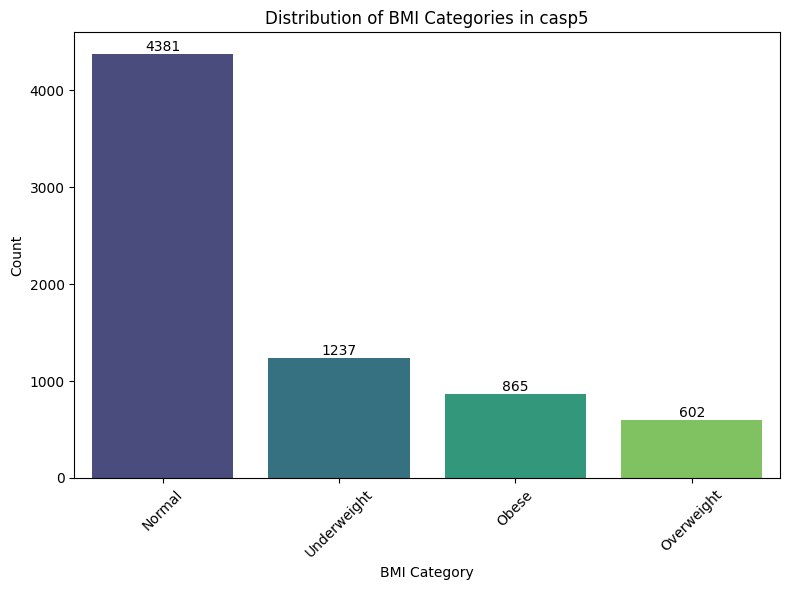

In [13]:
def plot_bmi_categories(processed_dfs, feature):
    for name, df in processed_dfs.items():
        # Count the occurrences of each category
        category_counts = df[f'{feature}_category'].value_counts()

        # Plot the counts
        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

        # Annotate counts above each bar
        for i, count in enumerate(category_counts.values):
            ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

        # Customize plot
        plt.title(f"Distribution of BMI Categories in {name}")
        plt.xlabel("BMI Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_bmi_categories(processed_dataframes,'bmi1')


/tmp/ipykernel_10380/2341734629.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('', np.nan, inplace=True)


Number of records with NaN value in sex in casp5: 0
X:  (2303, 343)
y:  (2303,)
Original class distribution:
bmi1_category
Normal         1428
Underweight     416
Obese           289
Overweight      170
Name: count, dtype: int64

Resampled class distribution:
bmi1_category
Normal         1428
Obese          1428
Overweight     1428
Underweight    1428
Name: count, dtype: int64
Generating SHAP summary plot for class 0
(2303, 343)


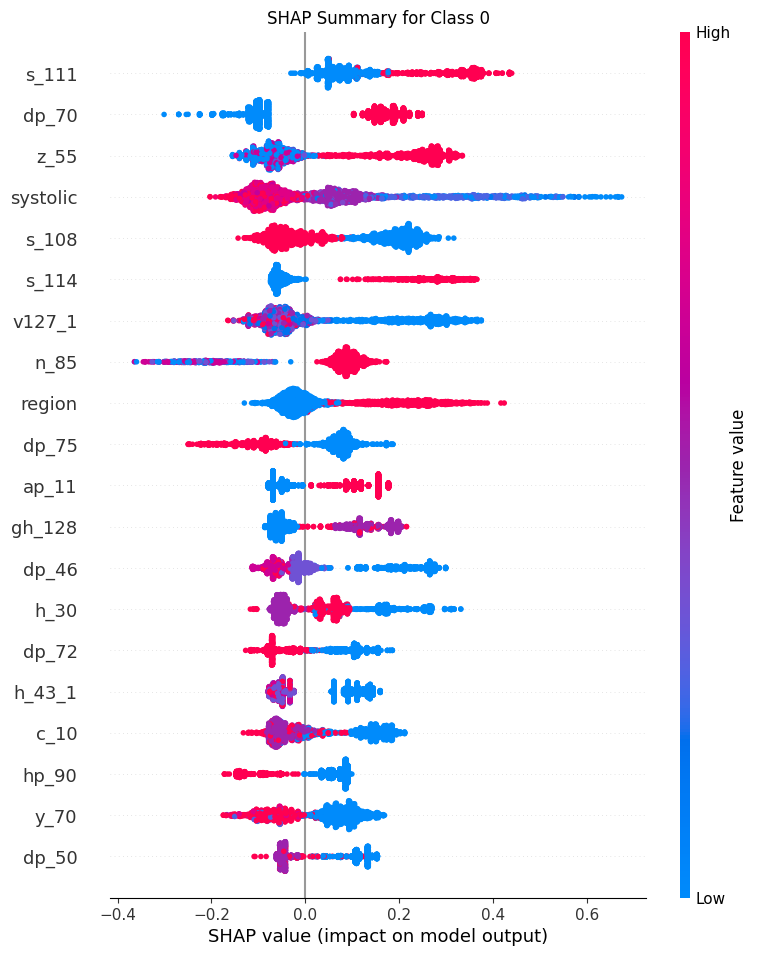

Generating SHAP summary plot for class 1
(2303, 343)


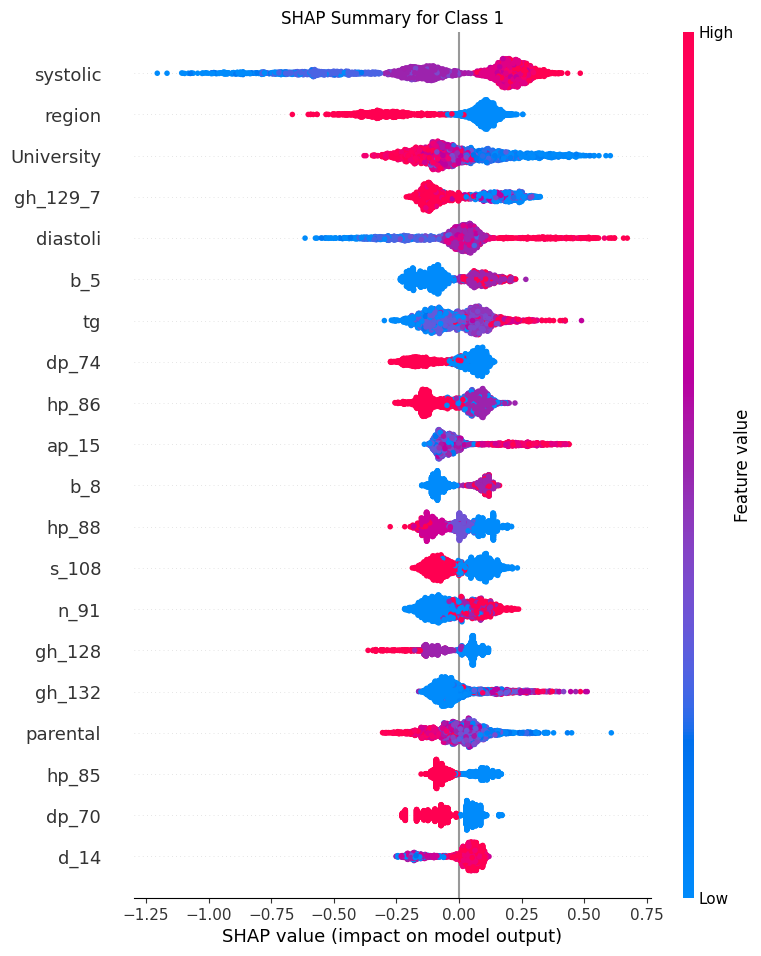

Generating SHAP summary plot for class 2
(2303, 343)


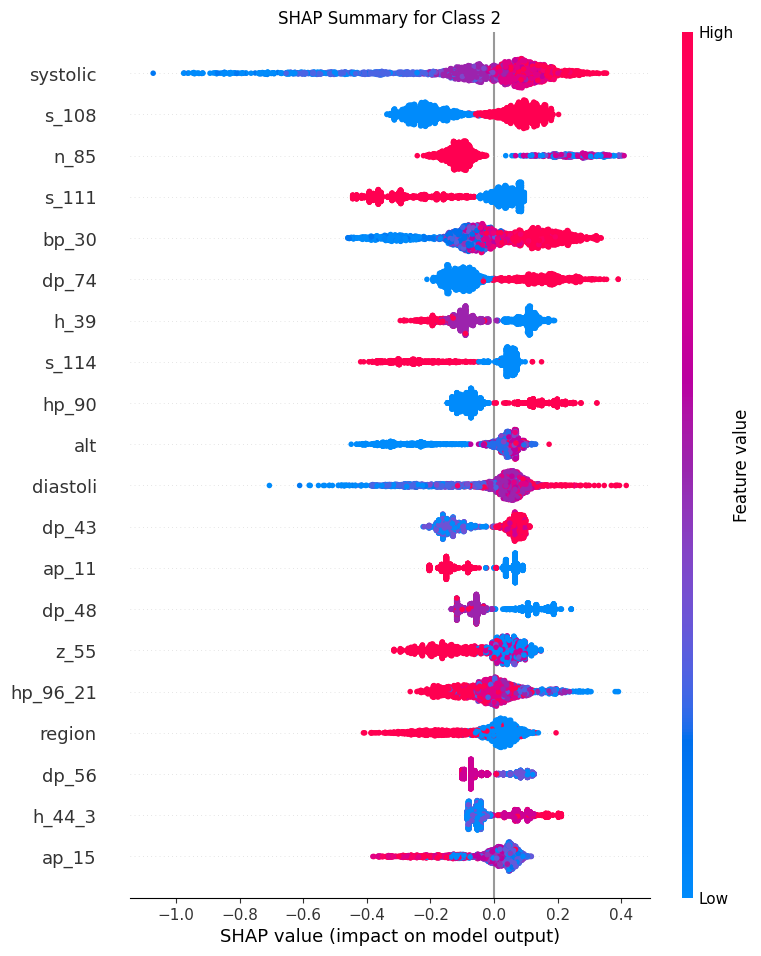

Generating SHAP summary plot for class 3
(2303, 343)


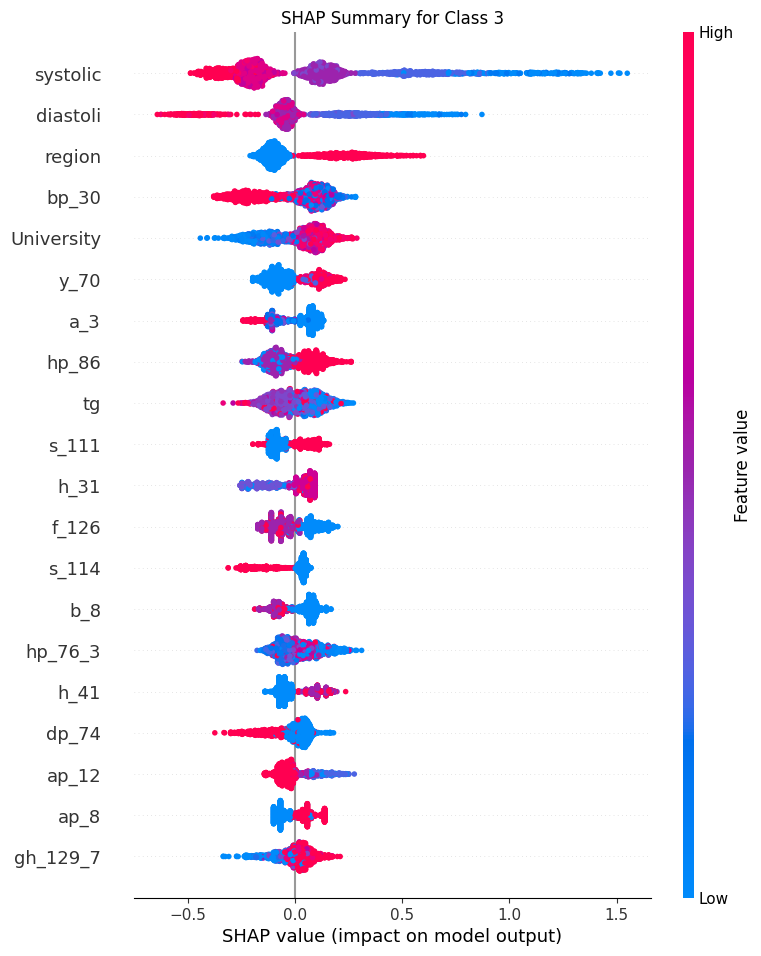

X:  (2773, 343)
y:  (2773,)
Original class distribution:
bmi1_category
Normal         1689
Underweight     476
Obese           355
Overweight      253
Name: count, dtype: int64

Resampled class distribution:
bmi1_category
Normal         1689
Obese          1689
Overweight     1689
Underweight    1689
Name: count, dtype: int64
Generating SHAP summary plot for class 0
(2773, 343)


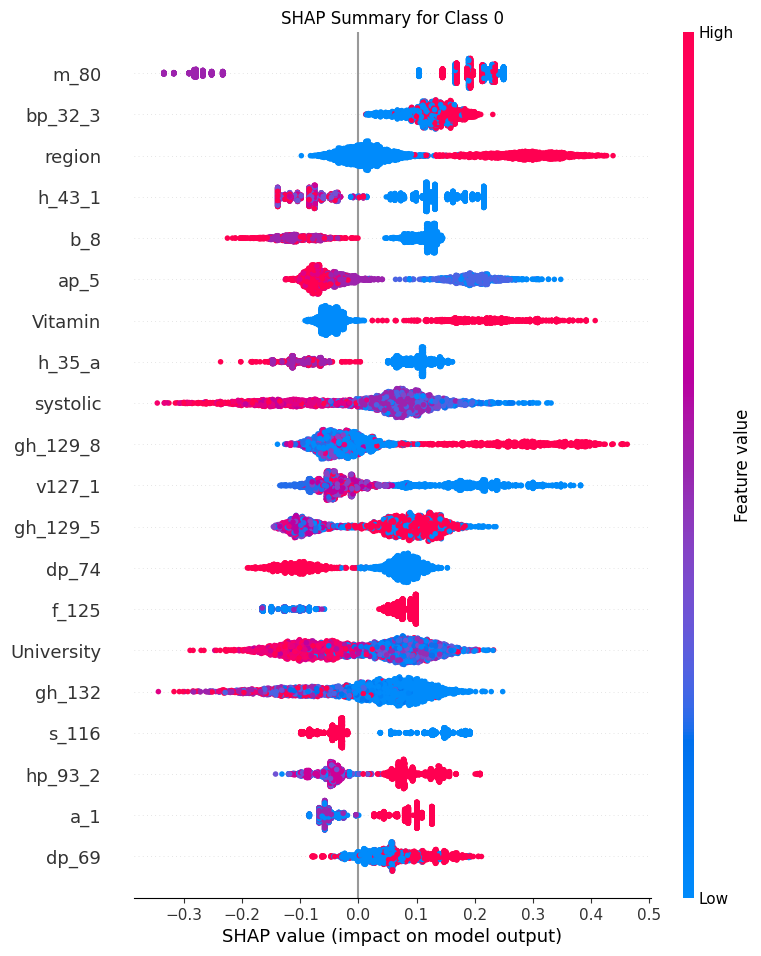

Generating SHAP summary plot for class 1
(2773, 343)


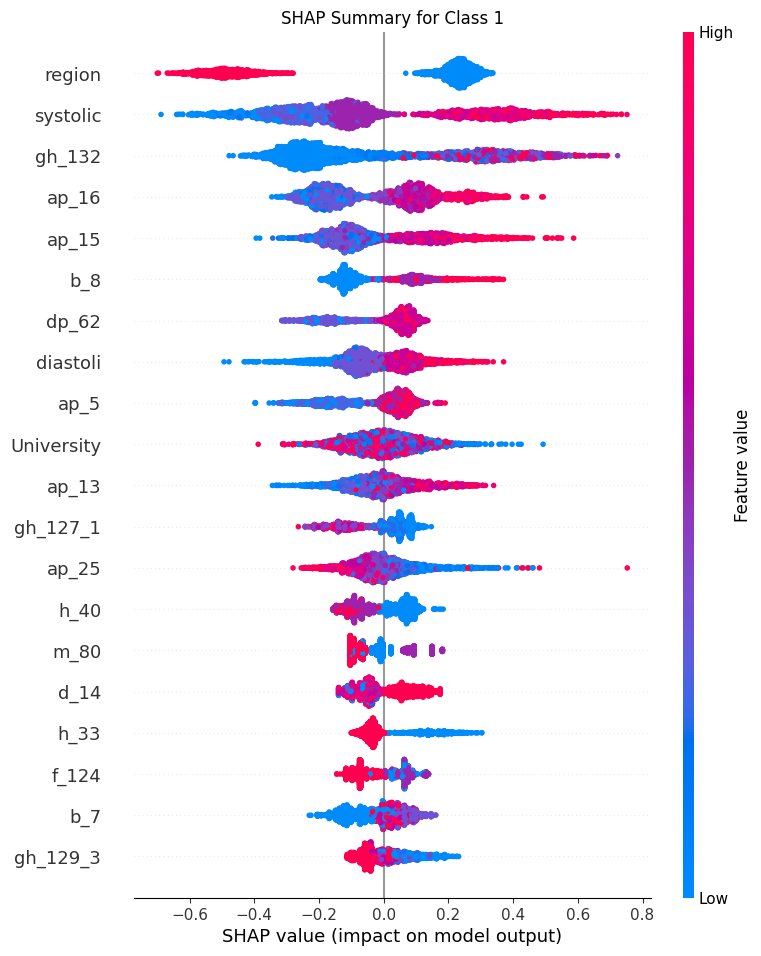

Generating SHAP summary plot for class 2
(2773, 343)


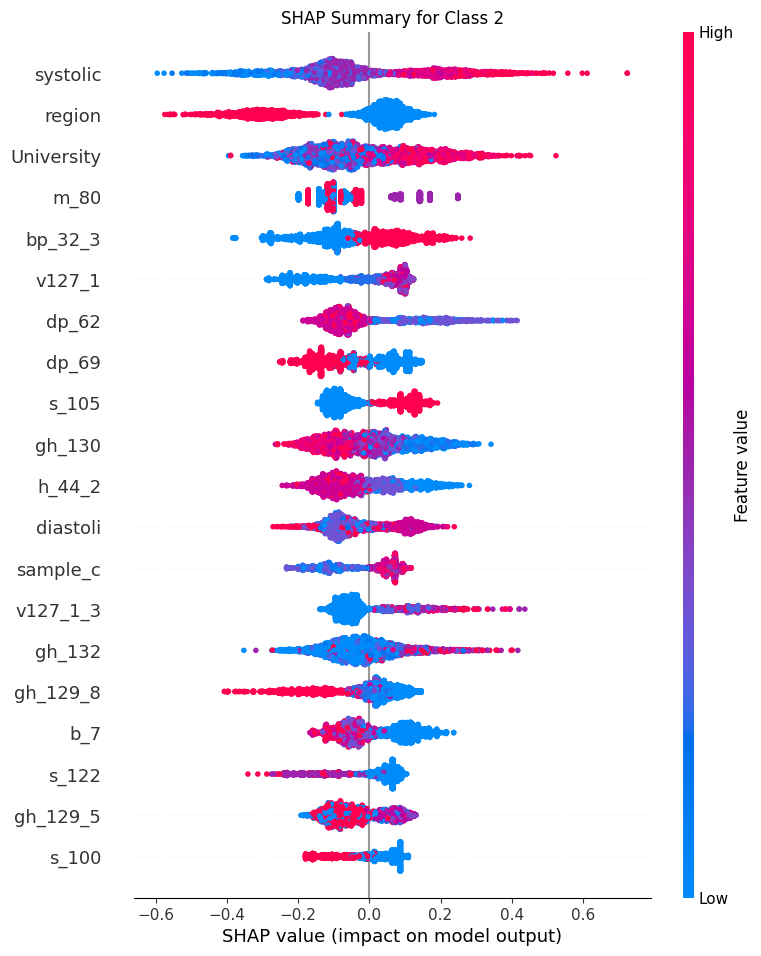

Generating SHAP summary plot for class 3
(2773, 343)


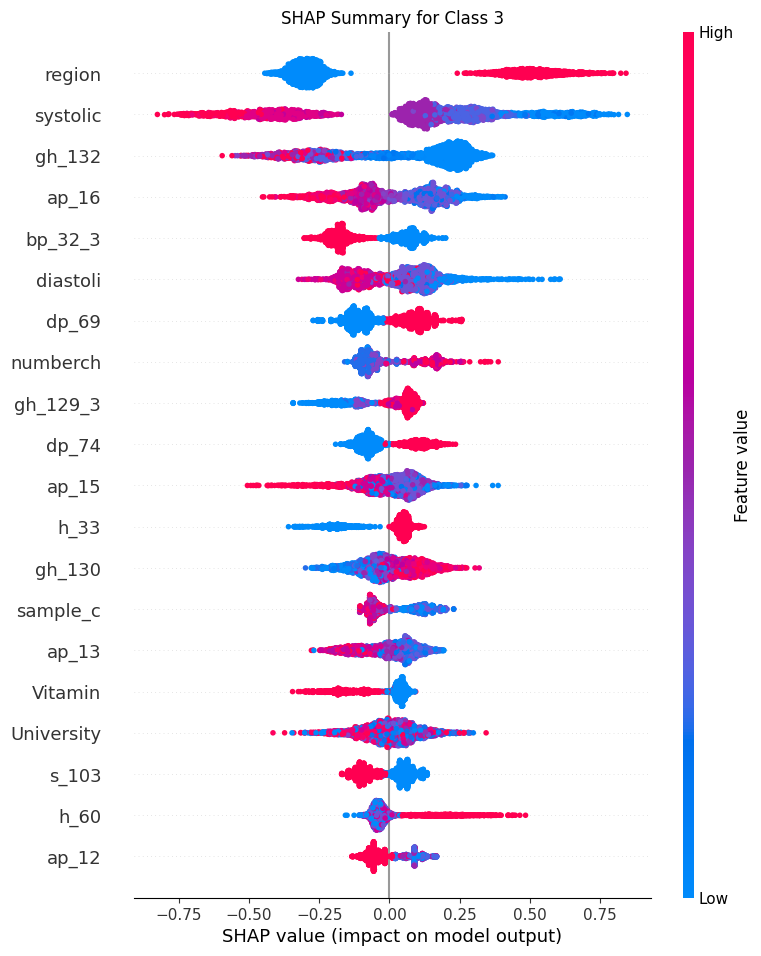

X:  (2009, 343)
y:  (2009,)
Original class distribution:
bmi1_category
Normal         1264
Underweight     345
Obese           221
Overweight      179
Name: count, dtype: int64

Resampled class distribution:
bmi1_category
Normal         1264
Obese          1264
Overweight     1264
Underweight    1264
Name: count, dtype: int64
Generating SHAP summary plot for class 0
(2009, 343)


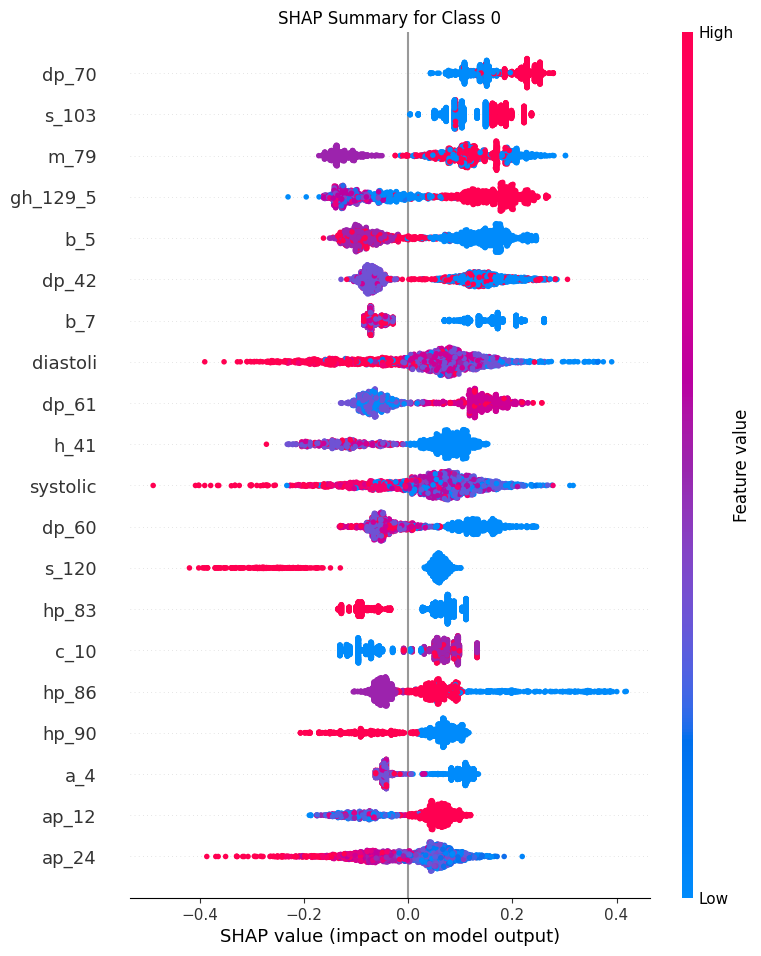

Generating SHAP summary plot for class 1
(2009, 343)


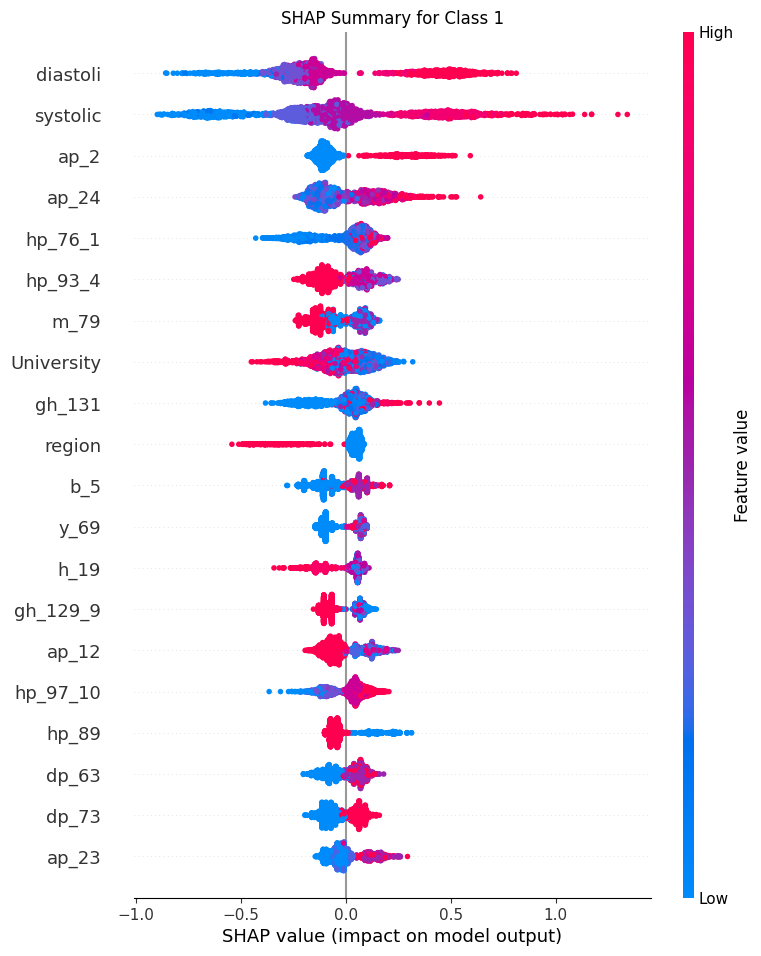

Generating SHAP summary plot for class 2
(2009, 343)


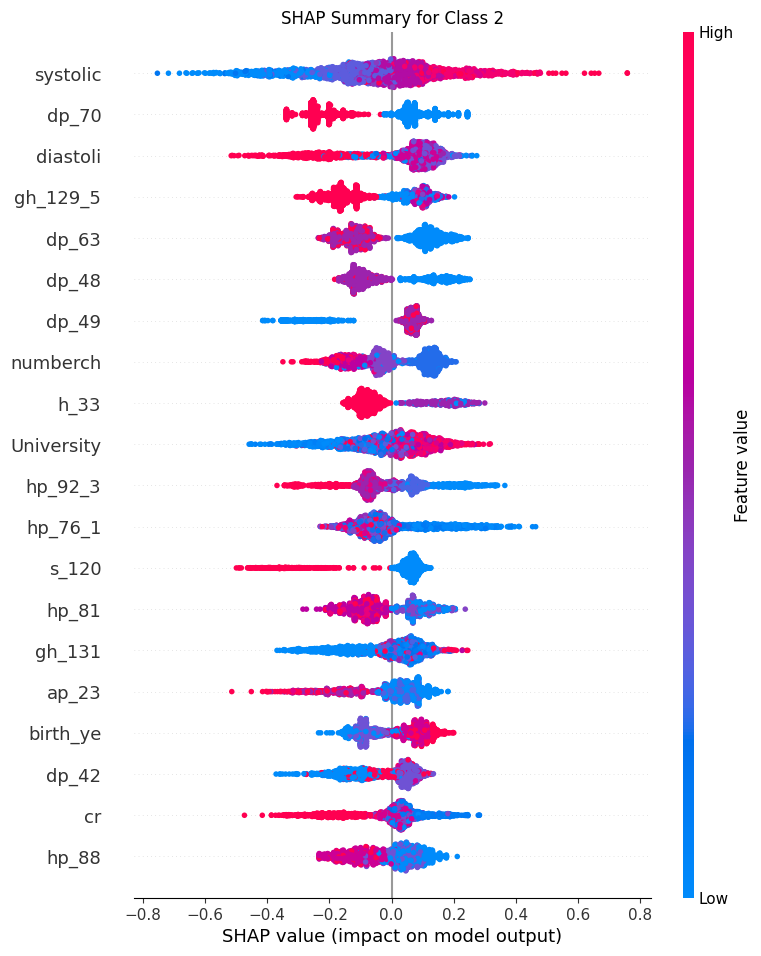

Generating SHAP summary plot for class 3
(2009, 343)


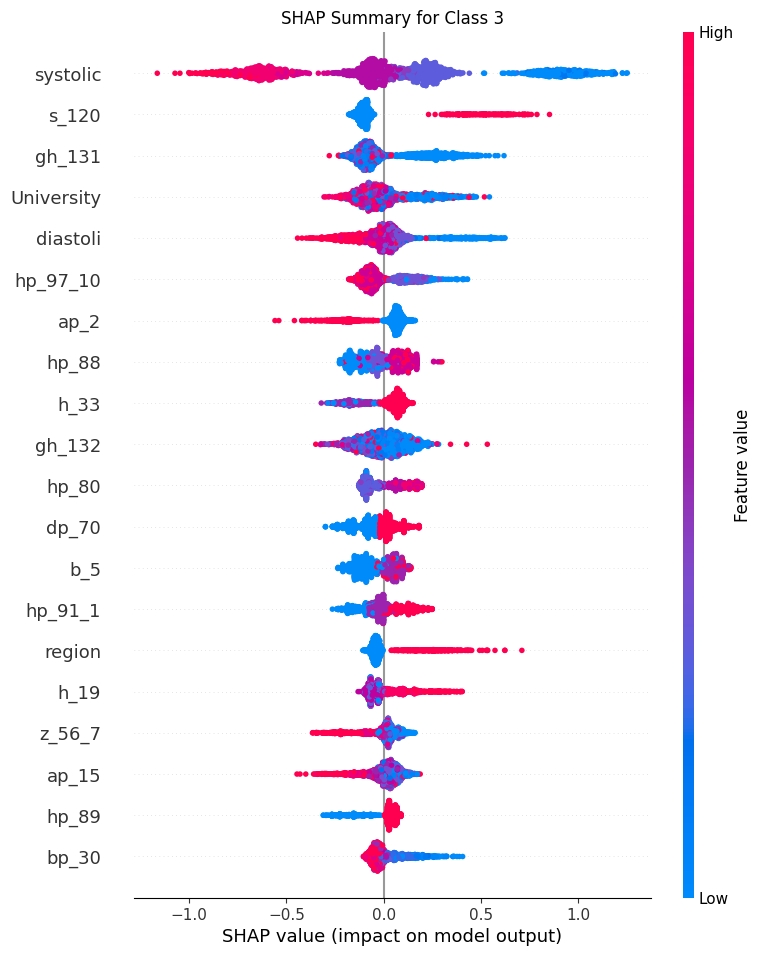

In [ ]:
# Define functions
def split_X_y(df_org):
    df = df_org.copy()
    X = df.drop(columns=['weight', 'bmi1', 'id2', 'hip', 'neck', 'wrist', 'waist', 'cluster',
                          'catage', 'cross', 'height','bmi1', 'bmi1_category','hp_101','b_6',
                          'hp_100','hp_101','hp_102','hp_103','hp_104','hp_105'], axis=1)
    y = df['bmi1_category']
    print('X: ',X.shape)
    print('y: ',y.shape)

    return X, y

def select_features(X, y, method, k=50, active=False):
    if active:
        selector = SelectKBest(method, k=k)
        selector.fit(X, y)
        return X.columns[selector.get_support()].tolist()
    else:
        return X.columns.tolist()

def train_catboost(X_train, y_train, iterations=100, random_state=42):
    model = CatBoostClassifier(iterations=iterations, random_seed=random_state, verbose=0)
    model.fit(X_train, y_train)
    return model, iterations

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return {"accuracy": accuracy, "report": report}

def process_and_train_model_for_each_age(final_dfs, catage, k=20):
    for name, df in final_dfs.items():
        results = []
        for cat in catage:
            # Filter dataset for the specific age
            df_age = df[df['catage'] == cat]
            if df_age.empty:
                continue

            X, y = split_X_y(df_age)
            resampling_pipeline = Pipeline([
                ('smote', SMOTE(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42))
            ])
            # Resample the dataset
            X_resampled, y_resampled = resampling_pipeline.fit_resample(X, y)

            print(f"Original class distribution:\n{y.value_counts()}")
            print(f"\nResampled class distribution:\n{y_resampled.value_counts()}")

            X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
            selected_features = select_features(X_train, y_train, f_classif, k=k, active=False)
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            catboost_model, iterations = train_catboost(X_train_selected, y_train)
            catboost_metrics = evaluate_model(catboost_model, X_test_selected, y_test)

            # Calculate feature importance
            feature_importance = catboost_model.get_feature_importance(prettified=False)
            explainer = shap.TreeExplainer(catboost_model)
            shap_values = explainer.shap_values(X)
            num_classes = shap_values.shape[-1]  # Number of classes (last dimension of SHAP values)
            for class_index in range(num_classes):
                print(f"Generating SHAP summary plot for class {class_index}")
                
                # Extract SHAP values for this class
                class_shap_values = shap_values[:, :, class_index]  # Shape: (4044, 343)
                # Plot SHAP summary for the selected class
                shap.summary_plot(class_shap_values, X, show=False)
                plt.title(f"SHAP Summary for Class {class_index}")
                plt.show()
            # Append results
            results.append({
                "catage": cat,
                "accuracy": catboost_metrics['accuracy'],
                "num_samples": len(df_age),
                "classification_report": catboost_metrics['report']
                # ,"top_features": ", ".join(top_features)
            })

        return results,shap_values,X_train_selected

input_dfs = {'casp5':df_5}
processed_dataframes = preprocess(input_dfs)
final_dfs = calculate_percentiles(processed_dataframes, filtered_df)
# Plot BMI category distribution
catage = range(1,4)  
# results = process_and_train_model_for_each_age(final_dfs,catage)
results,shap_values,X_train_selected = process_and_train_model_for_each_age(final_dfs,catage)

results_df = pd.DataFrame([{
"catage": r["catage"],
"accuracy": r["accuracy"],
"num_samples": r["num_samples"],
# "top_features": r["top_features"],
"classification_report": r["classification_report"]
} for r in results])

# results_df.to_csv("catage_based_model_results_boys_casp5.csv", index=False)
# print("Results saved to catage_based_model_results.csv.")

In [30]:

shap_values.shape

(4044, 343, 4)

In [26]:
X_train_selected.shape

(4044, 343)

Generating SHAP summary plot for class 0


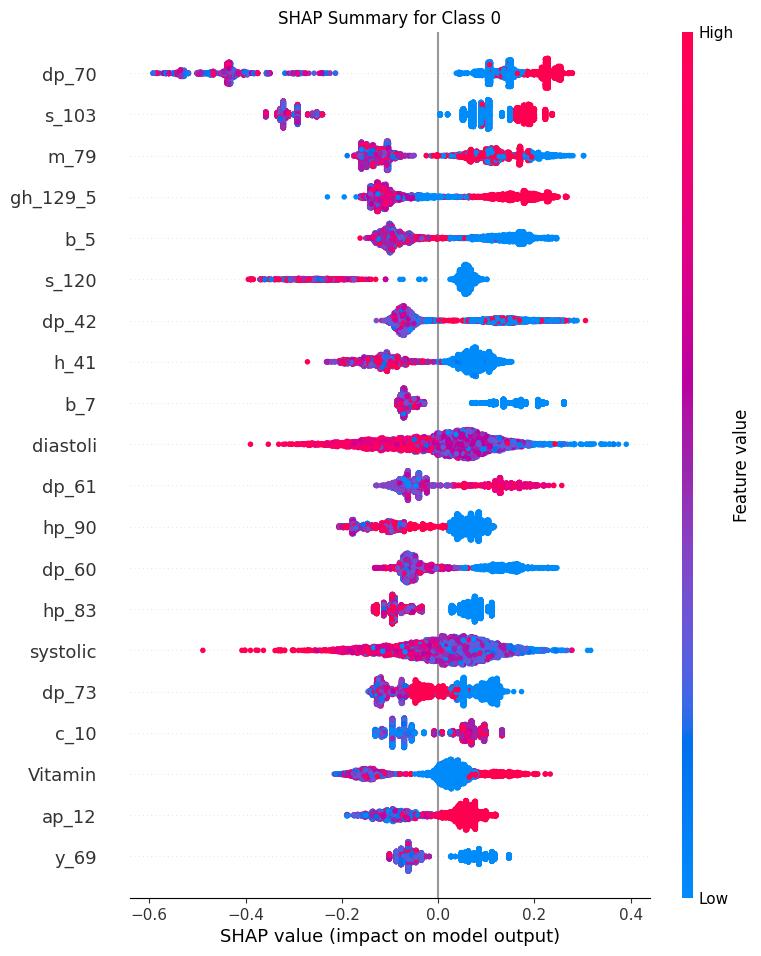

Generating SHAP summary plot for class 1


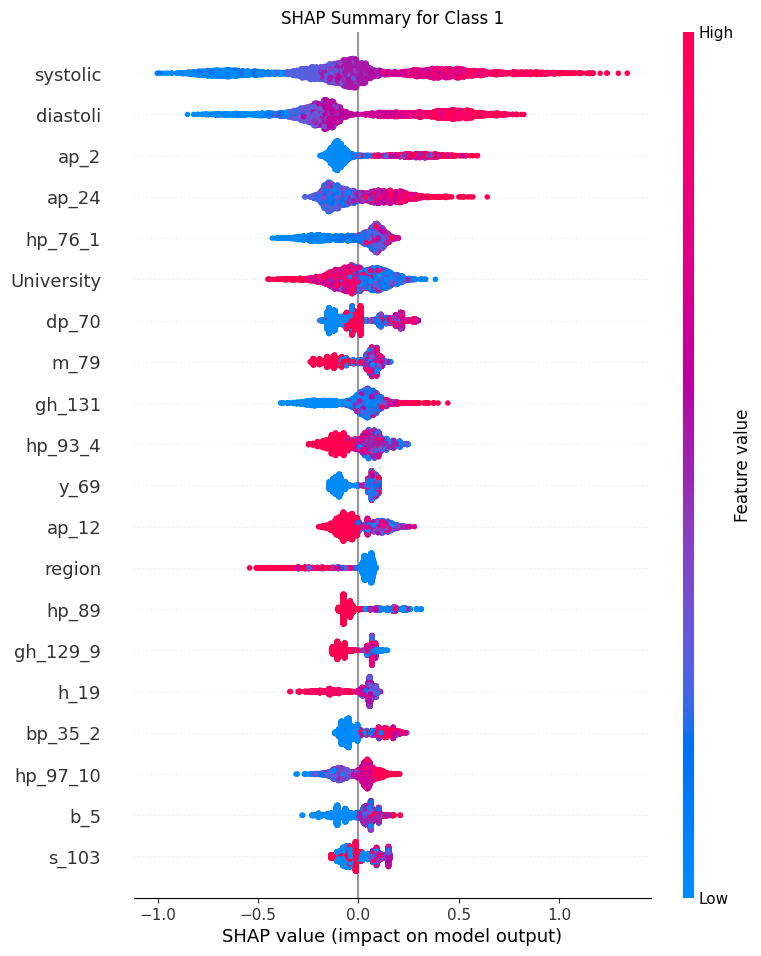

Generating SHAP summary plot for class 2


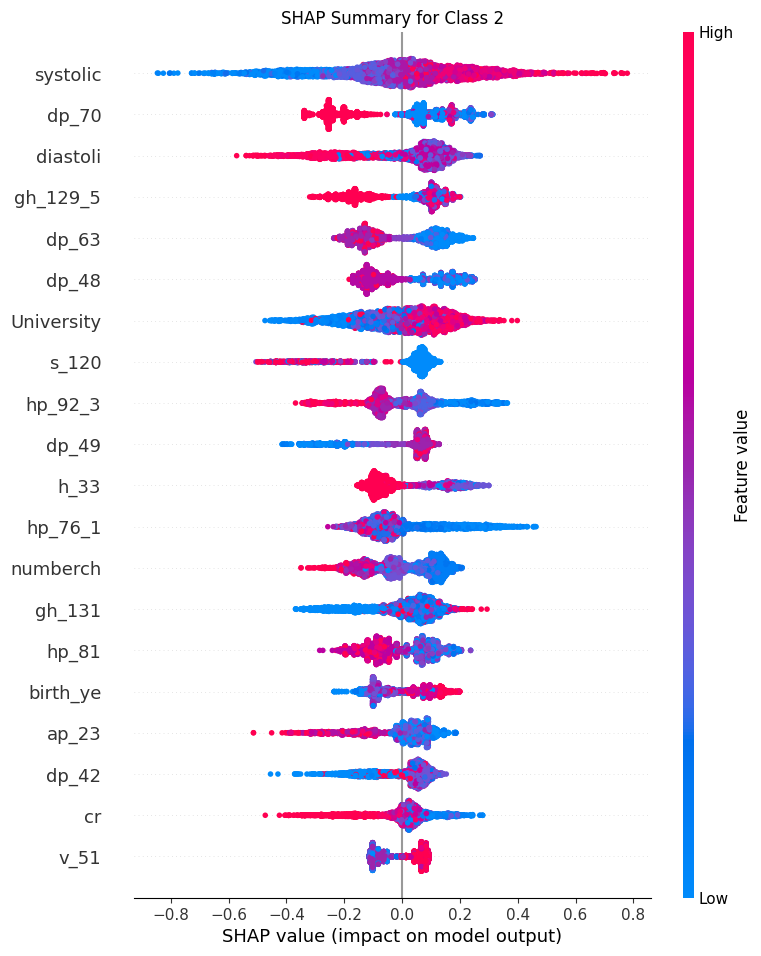

Generating SHAP summary plot for class 3


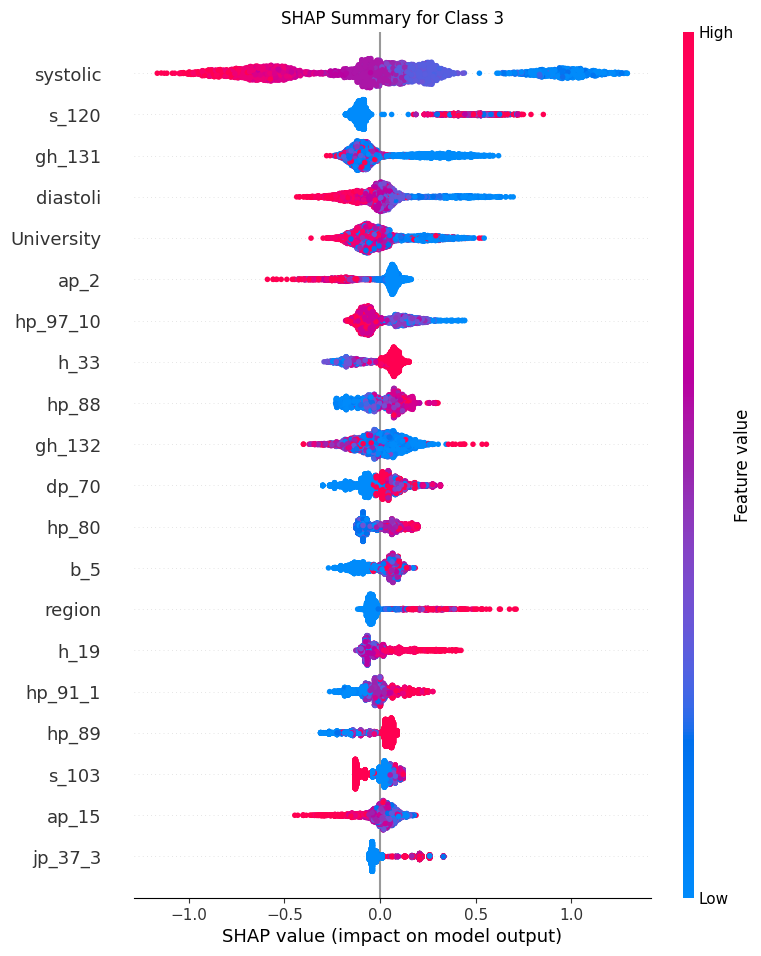

In [31]:
num_classes = shap_values.shape[-1]  # Number of classes (last dimension of SHAP values)
for class_index in range(num_classes):
    print(f"Generating SHAP summary plot for class {class_index}")
    
    # Extract SHAP values for this class
    class_shap_values = shap_values[:, :, class_index]  # Shape: (4044, 343)
    
    # Plot SHAP summary for the selected class
    shap.summary_plot(class_shap_values, X_train_selected, show=False)
    plt.title(f"SHAP Summary for Class {class_index}")
    plt.show()